# Custom CNN Distribution <a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="Custom CNN Distribution"></a>

This section showcases how a machine learning model can be distributed using standard dask methods. The face and noface images are loaded into dask arrays. These are rechunked so there is approximatly 333 images in a chunk. With 4000 images this creates roughly 12 majour chunks to be processed on 6 workers. These are persisted and passed into the custom cnn distribution.

### Algorithm Daskability 
An issue with distributed machine learning is that gradient descent cannot be co-ordinated seemlessly between the workers without a lot of slow interworker communication. This means the workers have to train on different data seperatly with the results being merged intermitantly. This implimentation splits the data evenly among the workers and combines the results after each worker has trained one "epoch" on the all data it has. When the workers have finished the weights are compared by the jupyter machine. The weights with the lowest loss are kept and the others are discarded. These weights are saved on each worker for another training.

### Memory Between Worker Tasks
The workers have 1/6 of the data saved on them but there are 12 chunks. The worker needs to have knowledge of the weights that were trained on the previous chunk. No solution was found to impliment this with python variables on dask. This was solved by saving the weights to a local pickle file. When a second chunk is loaded in the worker can read the old weights and carry on training from that point.

### Tensorflow Non Compatability
The CNN model variable could not be passed as a regular python variable to a function to be ran on a worker. This created an error. To solve this issue a g6.py file was created with the cnn variable pre built on it. This file is saved on each worker. Thus the cnn could be called in each worker with import g6, g6.cnn. Additional functions used by the worker are also placed on the g6 file. This reduces traffic on the cluster when running these functions on the workers.

### Unmanaged Memory
There were memory issues. The unmanged memory continuously increased at a high pace. Trimming with the malloc function only released a small proportion of the memory. The extensive use of the del function helped dramatically. An earlier version of the code used a dask data frame instead of dask arrays. This helped to keep the lables with the images. Althought the numpy array images only fitted into a 'cell' of the data frame if it was contained within list. This prevented dask from accuratly measuring the size of the data within the data frame. which contributed significantly to the unmanaged memory issue. This was resolved by switching to the dask array architecture.

### Dask Options
When it comes to distribution in dask there are many options. We implimented the code both in a dask dataframe and in dask arrays. We finally used the dask arrays. Although dask bags were going to be our next try if it were to fail. Dask also allows a very flexible framework with dask delayed. Many combinations of these options were thought of and a few were trialed to find the final working solution that performed adequatly. The images are loaded as dask arrays. The face images are stacked ontop of the noface images. Thus the lables are encoded in a dimension of the dask array. This is chunked and persisted across the workers. These chunks are 

In [73]:
#make the g6.py file to move some functions straight to the workers
#This reduces traffic when running these functions on the workers
# It was also the only way to get the cnn on the worker, as it couldn't be passed in a function.

#remove old g6.py file
try:
    os.system('rm g6.py')
    client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "g6.py")))
except: print("No g6.py file was on the workers or the current machine, adding it now")
#the code below is displayed as such for syntax highlighting. It is then made into a string and written to a file to be sent to the workers and used as a g6 package
from tensorflow.keras import models, layers
import tensorflow as tf
import pickle
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

cnn = build_cnn()

#extracting the weights from a cnn
def get_w(cnn):
    layer_w = [lay.get_weights() for lay in cnn.layers]
    return layer_w

#changing the weights of the cnn
def set_w(cnn,weights):
    for lay,w in zip(cnn.layers, weights):
        lay.set_weights(w)
    return cnn


#make a pickle file on the worker with the initial weights
def weights_init():
    weights = get_w(cnn)
    f_weights = open(Path(path_weights), 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    
# once the weights have been trained. This brings them from the workers to this machine for validation
def weights_get():
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    return weights
#weights = list(client.run(weights_get).values())

def loss_get():
    f_loss = open(path_loss,'rb')
    loss = pickle.load(f_loss)
    f_loss.close()
    return loss
#weights = list(client.run(weights_get).values())

def acc_get():
    f_acc = open(path_acc,'rb')
    acc = pickle.load(f_acc)
    f_acc.close()
    return acc
#weights = list(client.run(weights_get).values())



#now we have the best weights we need to write them to each worker so they can re-train from the best weights
def weights_set_best(weights_best):
    f_weights = open(path_weights,'wb')
    pickle.dump(weights_best,f_weights)
    f_weights.close()
    del f_weights, weights_best
    
contents = "\
from tensorflow.keras import models, layers\n\
import tensorflow as tf\n\
import pickle\n\
path_weights='"+str(path_weights)+"'\n\
def build_cnn():\n\
    cnn = models.Sequential([\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        #dense\n\
        layers.Flatten(),\n\
        layers.Dense(50, activation='relu'),\n\
        layers.Dense(2, activation='softmax')\n\
    ])\n\
    # compile\n\
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\
    #summary\n\
    #print(cnn.summary())\n\
    return cnn\n\
\n\
cnn = build_cnn()\n\
\n\
def get_w(cnn):\n\
    layer_w = [lay.get_weights() for lay in cnn.layers]\n\
    return layer_w\n\
#changing the weights of the cnn\n\
def set_w(cnn,weights):\n\
    for lay,w in zip(cnn.layers, weights):\n\
        lay.set_weights(w)\n\
    return cnn\n\
\n\
#make a pickle file on the worker with the initial weights\n\
def weights_init():\n\
    weights = get_w(cnn)\n\
    f_weights = open(path_weights, 'wb')\n\
    pickle.dump(weights, f_weights)\n\
    f_weights.close()\n\
    \n\
# once the weights have been trained. This brings them from the workers to this machine for validation\n\
def weights_get():\n\
    f_weights = open(path_weights,'rb')\n\
    weights = pickle.load(f_weights)\n\
    f_weights.close()\n\
    return weights\n\
#now we have the best weights we need to write them to each worker so they can re-train from the best weights\n\
def weights_set_best(weights_best):\n\
    f_weights = open(path_weights,'wb')\n\
    pickle.dump(weights_best,f_weights)\n\
    f_weights.close()\n\
    del f_weights, weights_best"

#write the file this this machine on the same dir as this notebook
f_py = open("g6.py",'w')
f_py.write(contents)
f_py.close()

#upload the file to the workers so it can be imported on the workers
client.upload_file('g6.py')

#use the following commmand to remove unwanted files that have been uploaded
#client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "file.py")))

{'tcp://10.67.22.108:36153': {'status': 'OK'},
 'tcp://10.67.22.110:35555': {'status': 'OK'},
 'tcp://10.67.22.138:41457': {'status': 'OK'},
 'tcp://10.67.22.203:39515': {'status': 'OK'},
 'tcp://10.67.22.67:38069': {'status': 'OK'},
 'tcp://10.67.22.75:35645': {'status': 'OK'}}

In [74]:
#You can checked it worked by initalising the weights
# import g6
# client.run(g6.weights_init)

In [12]:
#define the function that will train on each partition. It will load weights, train, then write the improved weights over the same file
@dask.delayed
def train(chunk):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    #---------------------------------------------------
    #get init/best weights from pickle file 
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    del f_weights
    cnn = g6.set_w(g6.cnn, weights)
    fit = cnn.fit(data,labels, epochs = 1, shuffle=True)
    loss = fit.history['loss'][-1]
    acc = fit.history['accuracy'][-1]
    
    f_acc = open(path_acc, 'wb')
    pickle.dump(acc, f_acc)  
    f_acc.close()
    
    f_loss = open(path_loss, 'wb')
    pickle.dump(loss, f_loss)  
    f_loss.close()
    
    weights = g6.get_w(cnn)
    f_weights = open(path_weights, 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    del f_weights, weights, fit, data, labels, cnn

#because this function returnes nothing, delayed was more convenient than dask.array.map_blocks()

In [13]:
#once the weights have been trained, we need to evaluate the accuracy they provide
# The workers find the acc of different chunks in parralell. The mean acc of the chunks is the overall accuracy.
#The function loads the weights from the same place the trainer saved them.
@dask.delayed
def evaluate(chunk,weights):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    
    cnn = g6.set_w(g6.cnn,weights)
    loss, acc = cnn.evaluate(data,labels)
    del cnn, loss
    return acc


In [14]:
from dask.array.image import imread
#this will load the saved images from file into a dask array
# it is stacked so the face images are on top of the noface images, this is the second axis
def getData(vis=False):    
    if vis:
        face = imread(str(path_face)+'/*').persist()
        noface = imread(str(path_noface)+'/*').persist()
        data = [face,noface]
        data = da.stack(data,axis=1)
        data.visualize()
        
    else:    
        face = imread(str(path_face)+'/*')
        noface = imread(str(path_noface)+'/*')
        data = [face,noface]
        data = da.stack(data,axis=1)
    #display(face)
    #display(noface)    
    #display(data)
    del face, noface
    return data

#data = getData(vis=True)

## Visualising Training 

In [15]:
#Visualising the training of one chunk
data=getData()
data=data.rechunk(chunks=(int(500/2),2,198,198,3)).persist()
data= data.to_delayed().ravel()
delayed = [train(d) for d in data]
delayed[0].visualize()
display(delayeds[0].visualize())
display(delayeds[1].visualize())
display(delayeds[2].visualize())


NameError: name 'delayeds' is not defined

## Visualising Validation

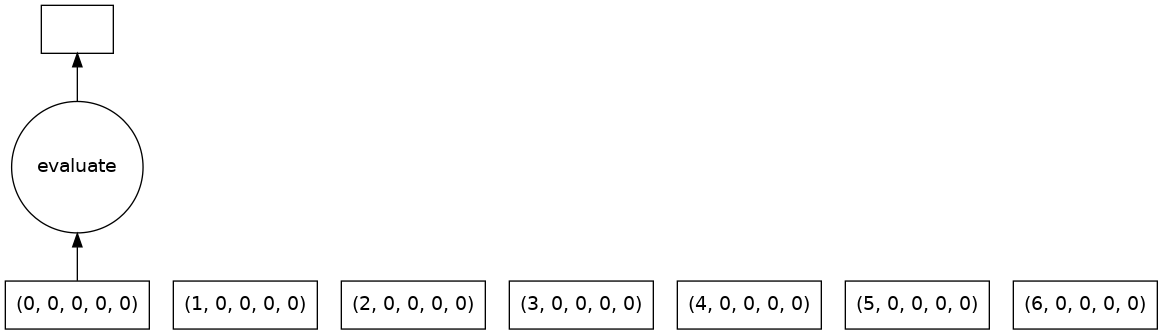

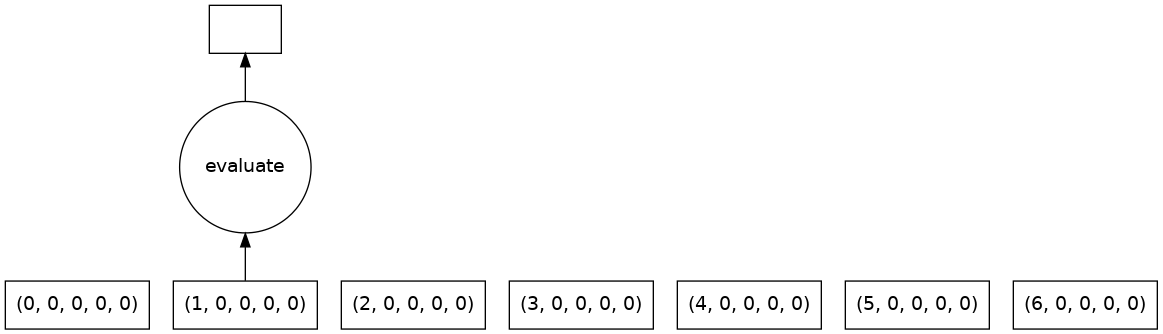

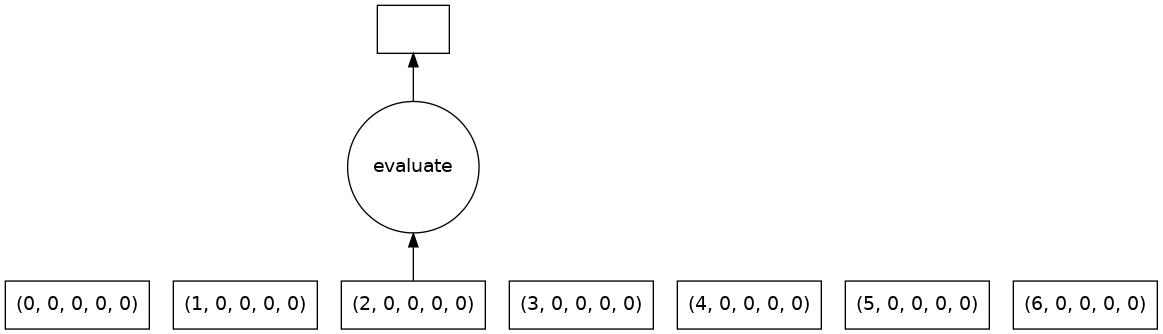

In [31]:
#Visualising the training of one chunk
data=getData()
data=data.rechunk(chunks=(int(500/2),2,198,198,3)).persist()
data=data.to_delayed().ravel()
delayed=[evaluate(d) for d in data]
display(delayed[0].visualize())
display(delayed[1].visualize())
display(delayed[2].visualize())

In [78]:
import g6 #our package we defined earlier, has weight file saving functions and the cnn variable

#The heart and soul
#This ties it all together to distribute the training of the cnn. On n workers we train data/n on each worker. data/n is split into chunks manageable on the ram. A worker loads in a chunk of its data/n and trains the cnn on it for 1 epochs. Then it saves the weights, training accuracy and loss to a file. When it gets the next chunk it loads the last weights and trains on top of them again. After it has repeated this for all of its chunks, we have a set of weights that has been trained on data/n. This happens for all n workers, then we have n sets of weights.

#These weights and their losses are loaded into the jupyter machine. The weights with the lowest loss is then saved into each worker for the next itteration of training.

#Then we do the distributed evaluation for the final best weights. Each worker has its data_eval/n saved locally in chunks. It loads one chunk at a time and evaluated the cnn accuracy with the weights being tested. Each worker returnes a collection of accuracies for each chunk evaluated. Finally all chunk accuracies are returned to this jupyter machine. Here we find the mean to know the true accuracy of the weights over all of the data. 

#images per chunk allows us to control how much the workers have to handle. I found chunking by bytes to be too inaccurate.
#frac_tr is the ratio of training to validation data. I suspect this should be kept low. Our goal is good performance analysis not a good cnn. With less training data it takes longer to train which amplifies performance gaps between systems. If both systems get 0.99 accuracy in 0.2 +- 0.02 seconds its difficult to say which is better. But if one is an inefficiant model it will show as each inefficiency adds up in a longer run. Also with a large validation set we get more accurate accuracy readings. This means our performance analysis for time to 0.95 accuracy is more reliable.    

#get and split the data
data = getData().persist()
frac_tr = 0.8

im_per_chunk=333

m_t = int(len(data)*frac_tr)
data_tr = data[:m_t].rechunk(chunks=(int(im_per_chunk/2),2,198,198,3)).persist()
data_val = data[m_t:].rechunk(chunks=(int(im_per_chunk/2),2,198,198,3)).persist()
wait(data_tr)

del data, frac_tr, m_t


def cnn_dist(data_tr, nitter=1, verbose=True):
    try: 
        del weights_best, loss_best, acc_best
    except: print('Another Run')
    
    data_tr = data_tr.to_delayed().ravel()
    #initialising the weights stored locally on the workers
    client.run(g6.weights_init)

    for i in range(nitter):
        if verbose: print('Training Itteration:',i)
        #train on the distributed training dataframe, loading and saving the weights from a file
        dd.compute(*[train(dtr) for dtr in data_tr])
        #del data_tr
        
        if verbose: print('getting trained weights:',i)
        #the weights have been trained. This brings them from the workers to this machine for validation
        weights = list(client.run(g6.weights_get).values())
        loss = list(client.run(loss_get).values())
        acc = list(client.run(acc_get).values())
        weights_best = weights[np.argmin(loss)]
        loss_best = np.min(loss)
        acc_best = np.max(acc)
        
        if verbose: print('The best training accuracy amongst the weights found is:',acc_best,'loss:',loss_best,'\n Setting the corresponding best weights for itteration:',i)
        client.run(g6.weights_set_best, weights_best)
        #The best weights found have been set, ready for the next training itteration
        
        del weights, loss, acc
    del data_tr
    return loss_best, acc_best, weights_best




In [79]:
from dask.distributed import performance_report
with performance_report(filename="cnn_dist_chunk333_itter5.html"):
    loss_best, acc_best, weights_best = cnn_dist(data_tr,nitter=5,verbose=True)

Another Run
Training Itteration: 0
getting trained weights: 0
The best training accuracy amongst the weights found is: 0.8042168617248535 loss: 0.7191608548164368 
 Setting the corresponding best weights for itteration: 0
Training Itteration: 1
getting trained weights: 1
The best training accuracy amongst the weights found is: 0.8614457845687866 loss: 0.6232593655586243 
 Setting the corresponding best weights for itteration: 1
Training Itteration: 2
getting trained weights: 2
The best training accuracy amongst the weights found is: 0.900602400302887 loss: 0.39477837085723877 
 Setting the corresponding best weights for itteration: 2
Training Itteration: 3
getting trained weights: 3
The best training accuracy amongst the weights found is: 0.9186747074127197 loss: 0.24249596893787384 
 Setting the corresponding best weights for itteration: 3
Training Itteration: 4
getting trained weights: 4
The best training accuracy amongst the weights found is: 0.9150943160057068 loss: 0.2502067685127

In [81]:
#Validation
data_val = data_val.to_delayed().ravel()
acc_val = np.mean(dd.compute(*[evaluate(dvl,weights_best) for dvl in data_val]))
print('The validation accuracy is:',acc_val)


The validation accuracy is: 0.8555988669395447


In [82]:
# run this cell to release the ram that the workers are hoarding. 
# only to be used for debugging memory leeks, there is a fancy way for automatic trimming
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://10.67.22.108:36153': 1,
 'tcp://10.67.22.110:35555': 1,
 'tcp://10.67.22.138:41457': 1,
 'tcp://10.67.22.203:39515': 1,
 'tcp://10.67.22.67:38069': 1,
 'tcp://10.67.22.75:35645': 1}

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
